In [1]:
import numpy as np
import random
import torch
import importlib
import os
from models.network import AutoEncoder, ImageAutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## folder for testing
testing_folder = r'./pretrain/image_encoder'
config_path = os.path.join(testing_folder, 'config.py')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

## dataload
### create dataset
data_path = r'./data/all_vox256_img/all_vox256_img_test.hdf5'

testing_flag = True
if os.path.exists(config.data_path) and not testing_flag:
    data_path = config.data_path

model_type = f"AutoEncoder-{config.encoder_type}-{config.decoder_type}" if config.network_type == 'AutoEncoder' else f"AutoDecoder-{config.decoder_type}"

samples = ImNetImageSamples(data_path=data_path)

In [4]:
samples.data_pixels.shape, samples.data_points.shape, samples.data_values.shape, samples.data_voxels.shape

((8762, 24, 1, 128, 128),
 (8762, 16384, 3),
 (8762, 16384, 1),
 (8762, 1, 64, 64, 64))

In [ ]:
### debugger
debugger = MyDebugger(f'Mesh-visualization-Image-{os.path.basename(config.data_folder)}-{model_type}',
                      is_save_print_to_file=False)
previous_dir = None
if previous_dir is not None:
    debugger.set_direcotry_name(previous_dir)

## loading index
epoch = 1000
use_phase = False
phase = 2
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase else ""}_{epoch}.pth')

sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True
file = open(debugger.file_path('obj_list.txt'), mode='w')

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

file_name = debugger.file_path('obj_list.txt')
args = [(samples[i][0][0], debugger.file_path(f'testing_{i}.off'), resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, file_name) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

((1, 128, 128), <matplotlib.image.AxesImage at 0x7f477f13d8b0>)

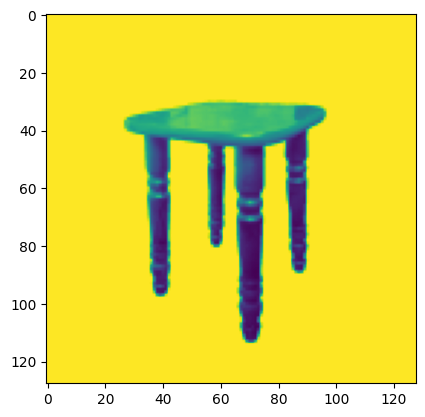

In [3]:
import cv2
target_wh = 128, 128

img = np.ones((1, target_wh[1], target_wh[0]), dtype=np.uint8) * 255

img_loaded = cv2.imread('masked-chair_1.png')
if img_loaded.shape[0] > img_loaded.shape[1]:
    res_wh = (
        int(img_loaded.shape[1] / (img_loaded.shape[0] // target_wh[0])), 
        target_wh[1]
    )
else:
    res_wh = (
        target_wh[0],
        int(img_loaded.shape[0] / (img_loaded.shape[1] // target_wh[1])), 
    )
    
additional_shift_wh = (
    (target_wh[0] - res_wh[0])//2,
    (target_wh[1] - res_wh[1])//2
)

img_loaded = cv2.resize(img_loaded, res_wh, interpolation=cv2.INTER_AREA)
img_loaded = img_loaded[..., 0]
img[:, additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = img_loaded
img = img.astype(np.float32)
img /= 255
img.shape, plt.imshow(img[0])

In [ ]:
indx = 0
obj_indx = 15

img, off_file, resolution, max_batch, space_range, thresh, obj_path, sur_point, f_name = final_args[indx][0][obj_indx]
net_path, conf_path = final_args[indx][1:-1]

plt.imshow(np.squeeze(img)), off_file, resolution, max_batch, space_range, thresh, obj_path, sur_point, f_name

In [52]:
spec = importlib.util.spec_from_file_location('*', conf_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

network = ImageAutoEncoder(config=config).to(device)

In [53]:
assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
auto_config = importlib.util.module_from_spec(auto_spec)
auto_spec.loader.exec_module(auto_config)

auto_encoder = AutoEncoder(config=auto_config).to(device)
network.set_autoencoder(auto_encoder)

In [54]:
network_state_dict = torch.load(network_path)
for key, item in list(network_state_dict.items()):
    if key[:7] == 'module.':
        network_state_dict[key[7:]] = item
        del network_state_dict[key]
network.load_state_dict(network_state_dict)
_ = network.eval()

In [55]:
img_torch = torch.from_numpy(img).float().to(device)
img_torch.shape

torch.Size([1, 128, 128])

In [56]:
embedding = network.image_encoder(img_torch.unsqueeze(0))
embedding.shape

torch.Size([1, 256])

In [57]:
#network.auto_encoder.save_bsp_deform(
#    inputs=None, file_path=file_path, resolution=resolution, max_batch=max_batch,
#    space_range=space_range, thershold_1=thershold, embedding=embedding
#)
thershold_1=thershold
thershold_2=0.01

In [58]:
### save_bsp_deform
## build the coordinates
coordinates = network.auto_encoder.create_coordinates(resolution, space_range)

## convex weigth
convex_layer_weights = network.auto_encoder.decoder.bsp_field.convex_layer_weights.detach().cpu().numpy()

## get plane
if embedding is None:
    inputs = inputs.unsqueeze(0)
    embedding = network.auto_encoder.encoder(inputs)

In [59]:
### generate_deform_bsp

if hasattr(network.auto_encoder.config, 'flow_use_split_dim') and network.auto_encoder.config.flow_use_split_dim:
    embedding_1 = embedding[:, :network.auto_encoder.config.decoder_input_embbeding_size]
    embedding_2 = embedding[:, network.auto_encoder.config.decoder_input_embbeding_size:]
else:
    embedding_1 = embedding
    embedding_2 = embedding
embedding_1.shape, embedding_2.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [446]:
embedding_2_old = embedding_2.clone()

In [474]:
embedding_2 = embedding_2 + embedding_2_old

In [60]:
#### AutoEncoder - extract_bsp_convex
plane_parms = network.auto_encoder.decoder.bsp_field.plane_encoder(embedding_2).cpu().detach().numpy()
plane_parms.shape

(1, 4, 4096)

In [61]:
convex_predictions = []
c_dim = network.auto_encoder.decoder.bsp_field.c_dim
for i in range(coordinates.size(1) // max_batch + 1):
    result = network.auto_encoder.decoder(embedding, coordinates[:, i * max_batch:(i + 1) * max_batch])
    result = result[0] # take only convexes info

    convex_prediction = result.squeeze(0).detach().cpu().numpy()
    convex_predictions.append(convex_prediction)
if len(convex_predictions) > 1:
    convex_predictions = np.concatenate(tuple(convex_predictions), axis=0)
else:
    convex_predictions = convex_predictions[0]
convex_predictions = np.abs(convex_predictions.reshape((resolution, resolution, resolution, c_dim)))
convex_predictions_float = convex_predictions < thershold_1
convex_predictions_sum = np.sum(convex_predictions_float, axis=3)
convex_predictions_sum.shape

(64, 64, 64)

In [78]:
coordinates.reshape(resolution, resolution, resolution, 3).shape

torch.Size([64, 64, 64, 3])

In [76]:
result.shape

torch.Size([1, 2144, 32])

In [62]:
result.shape, convex_predictions.shape

(torch.Size([1, 2144, 32]), (64, 64, 64, 32))

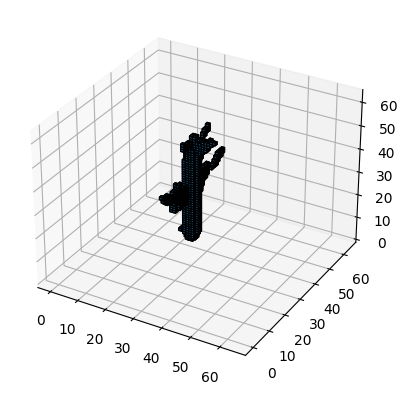

In [63]:
voxelarray = (convex_predictions_sum > 0).astype(np.int32)

ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(voxelarray, edgecolor='k')

In [69]:
convex_layer_weights.shape

(4096, 32)

In [ ]:
import seaborn as sns

sns.displot(convex_layer_weights[2])

In [84]:
convex_layer_weights[2]

array([ 1.0000095e+00,  1.6907556e-05,  1.0000064e+00, -1.4235640e-05,
        1.5663392e-05,  2.7195345e-06, -5.3299968e-06,  1.9242081e-05,
       -8.9870500e-06, -1.2059275e-05,  2.3237884e-05,  2.6524875e-05,
       -9.8906994e-06, -1.5647151e-05,  1.1926599e-05, -2.8383222e-06,
        9.9997026e-01,  1.0000159e+00, -1.0056090e-05,  5.7819620e-06,
       -4.5695657e-07,  2.9240726e-05, -1.8398065e-05,  9.9997789e-01,
        1.0000151e+00,  9.9999833e-01, -1.1646646e-05,  1.8141205e-05,
        1.6643255e-05, -1.3093563e-05,  1.4114652e-05, -1.8659748e-05],
      dtype=float32)

In [64]:
bsp_convex_list = []
p_dim = network.auto_encoder.decoder.bsp_field.p_dim
cnt = 0
for i in range(c_dim):
    slice_i = convex_predictions_float[:, :, :, i]
    if np.max(slice_i) > 0:  # if one voxel is inside a convex
        if np.min(
                convex_predictions_sum - slice_i * 2) >= 0:  # if this convex is redundant, i.e. the convex is inside the shape
            convex_predictions_sum = convex_predictions_sum - slice_i
        else:
            box = []
            for j in range(p_dim):
                if convex_layer_weights[j, i] > thershold_2:
                    a = -plane_parms[0, 0, j]
                    b = -plane_parms[0, 1, j]
                    c = -plane_parms[0, 2, j]
                    d = -plane_parms[0, 3, j]
                    box.append([a, b, c, d])
            if len(box) > 0:
                bsp_convex_list.append(np.array(box, np.float32))

        cnt += 1
    print(f"{i} done! ")
print(f'with {len(bsp_convex_list)} convex and enter to function {cnt}')

#### End extract_bsp_convex

0 done! 
1 done! 
2 done! 
3 done! 
4 done! 
5 done! 
6 done! 
7 done! 
8 done! 
9 done! 
10 done! 
11 done! 
12 done! 
13 done! 
14 done! 
15 done! 
16 done! 
17 done! 
18 done! 
19 done! 
20 done! 
21 done! 
22 done! 
23 done! 
24 done! 
25 done! 
26 done! 
27 done! 
28 done! 
29 done! 
30 done! 
31 done! 
with 17 convex and enter to function 22


In [75]:
len(bsp_convex_list), bsp_convex_list[0].shape

(17, (1204, 4))

In [65]:
from utils.other_utils import get_mesh_watertight, write_ply_polygon

vertices, polygons, vertices_convex, polygons_convex = get_mesh_watertight(bsp_convex_list)

Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0
Empty plane cnt : 0


In [66]:
from utils.ply_utils import triangulate_mesh_with_subdivide

vertices = np.array(vertices)
vertices, polygons = triangulate_mesh_with_subdivide(vertices, polygons)

vertices_result = network.auto_encoder.deform_vertices(embedding_1, max_batch, vertices)
vertices_result.shape

(24840, 3)

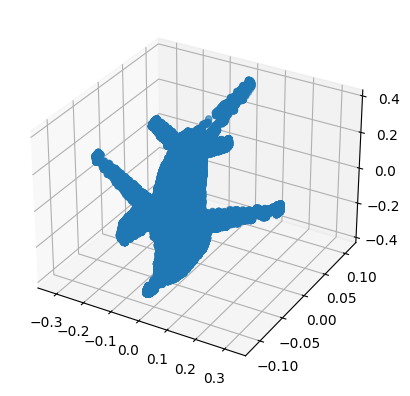

In [67]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_result[:, 0], vertices_result[:, 1], vertices_result[:, 2], marker='o')

In [68]:
write_ply_polygon('mesh_deformed.ply', vertices_result, polygons)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)

In [324]:
embedding_1.mean(), embedding_1.max(), embedding_1.min()

(tensor(0.5151, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0004, device='cuda:0', grad_fn=<MinBackward1>))

In [323]:
embedding_1_old = embedding_1.clone()

In [484]:
embedding_1_new = embedding_1_old + embedding_1

In [487]:
random_shift_t = torch.zeros((1, 128)).to(device)
random_shift_t[:, :1] = 0.01
random_shift_t[:, :20] = 1
random_shift_t[:, 100:] = -0.9
embedding_1_new = embedding_1_old + random_shift_t

In [488]:
vertices_result_new = network.auto_encoder.deform_vertices(embedding_1_new, max_batch, vertices)

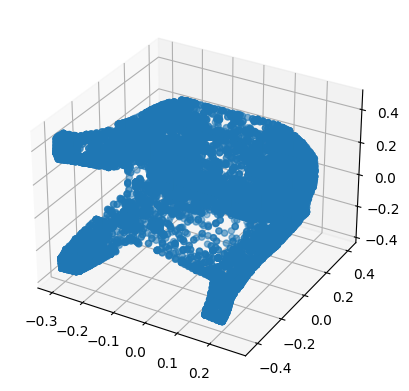

In [491]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_result_new[:, 0], vertices_result_new[:, 1], vertices_result_new[:, 2], marker='o')

In [492]:
write_ply_polygon('mesh_deformed_shifted.ply', vertices_result_new, polygons)